# Simple Chess Algorithm

Let's familiarize with the chess engine...

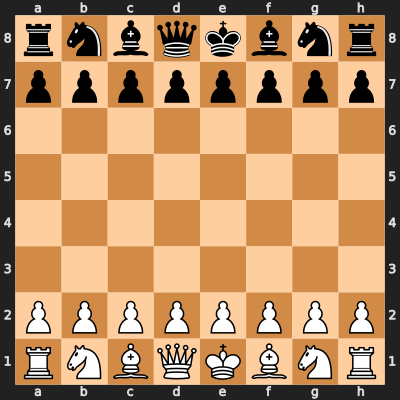

In [1]:
import chess
import chess.svg

board = chess.Board()

chess.svg.board(board, size=400)

What are the pieces worth? The algorithm needs a value for each piece in order to compute a score for each move.

In [2]:
def get_piece_value(piece: chess.Piece) -> int:
    if not piece:
        return 0
    symbol = piece.symbol().lower()
    if symbol == "p":
        return 1
    elif symbol == "n":
        return 3
    elif symbol == "b":
        return 3
    elif symbol == "r":
        return 5
    elif symbol == "q":
        return 9
    elif symbol == "k":
        # use some VERY high value for the king
        return 1337

# Minimax Pseudocode

```txt
function minimax(node, depth, maximizingPlayer):
    if depth = 0 or node is a terminal node:
        return evaluate(node)
    
    if maximizingPlayer:
        maxEval = -infinity
        for each child of node:
            eval = minimax(child, depth - 1, FALSE)
            maxEval = max(maxEval, eval)
        return maxEval
    else:
        minEval = +infinity
        for each child of node:
            eval = minimax(child, depth - 1, TRUE)
            minEval = min(minEval, eval)
        return minEval

```

In [3]:
import chess

INF = 2**31-1
DEPTH = 3

def evaluate(board: chess.Board) -> int:
    return sum(get_piece_value(board.piece_at(i)) for i in range(63))


def minimax(board: chess.Board, depth:int, maximize:bool):
    if depth == 0 or board.is_game_over():
        return evaluate(board)
    pass

    if maximize:
        best_score = -INF
        for move in board.legal_moves:
            board.push(move)
            score = minimax(board, depth -1, False)
            board.pop()
            best_score = max(score)
        return best_score
    else:
        lowest_score = INF
        for move in board.legal_moves:
            board.push(move)
            score = minimax(board, depth -1, False)
            board.pop()
            lowest_score = min(lowest_score, score)
        return lowest_score


def get_next_move(board: chess.Board) -> chess.Move:
    best_move = None
    best_score = -INF

    for move in board.legal_moves:
        board.push(move)
        score = minimax(board, depth=DEPTH, maximize=False)
        board.pop()
        if score > best_score:
            best_score = score
            best_move = move
    return best_move


So... What is the best move according to the `minimax` function?

In [4]:
move = get_next_move(board)

In [5]:
from IPython import display

def draw_board_with_move(move):
    arrow = chess.svg.Arrow(move.from_square, move.to_square, color="#0000cccc")
    svg = chess.svg.board(board, size=400, arrows=[arrow,])
    display.display(svg)

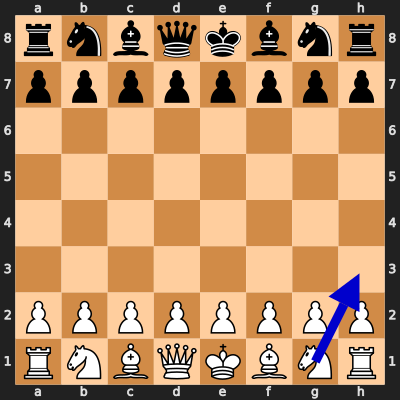

In [6]:
draw_board_with_move(move)


"A knight on the rim is grim."

In [7]:
board.push(move)

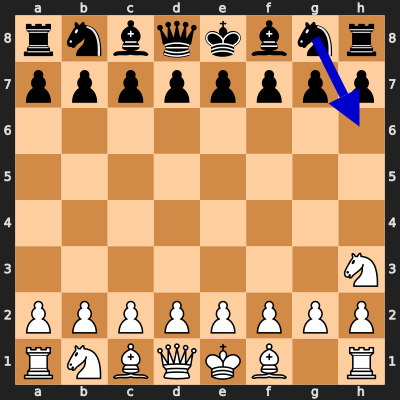

In [8]:
move = get_next_move(board)
draw_board_with_move(move)
board.push(move)

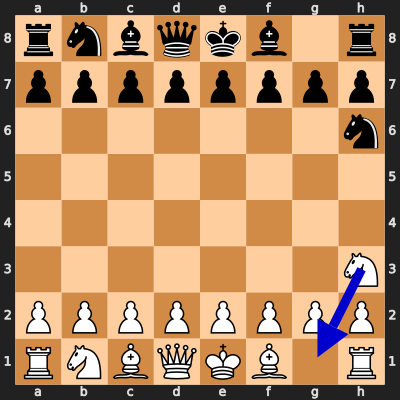

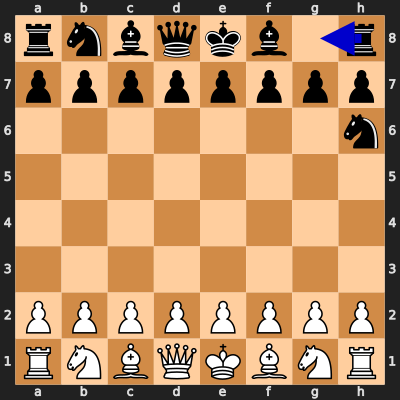

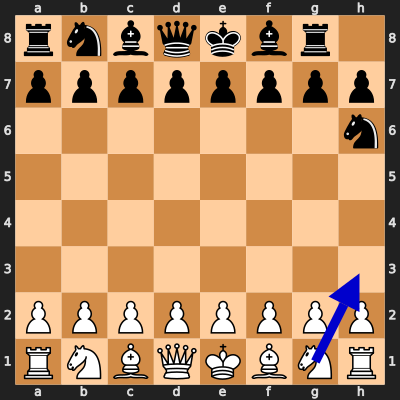

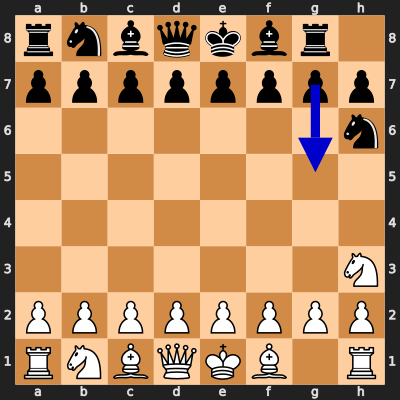

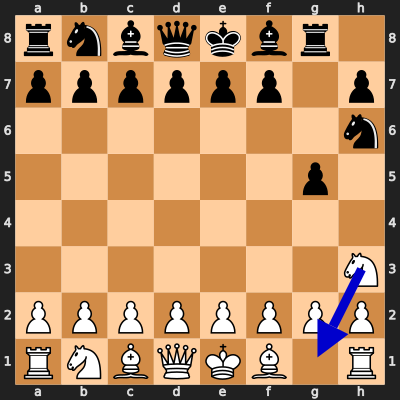

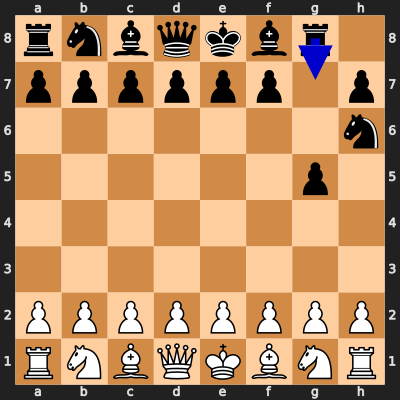

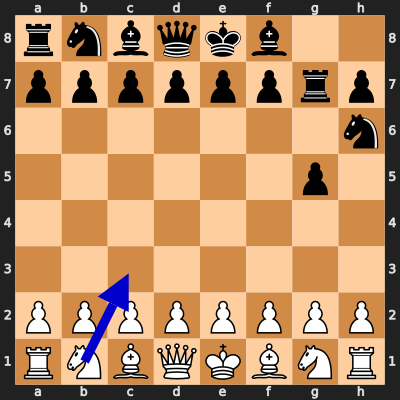

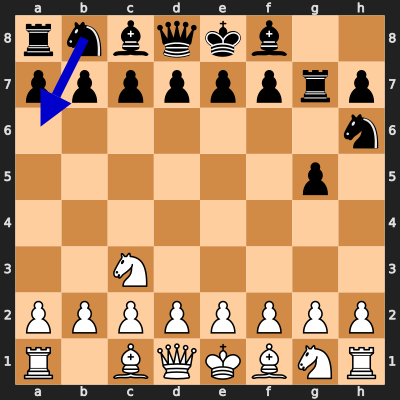

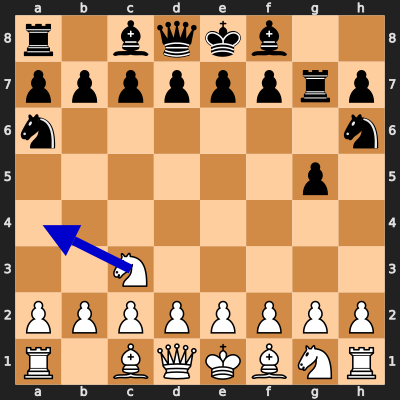

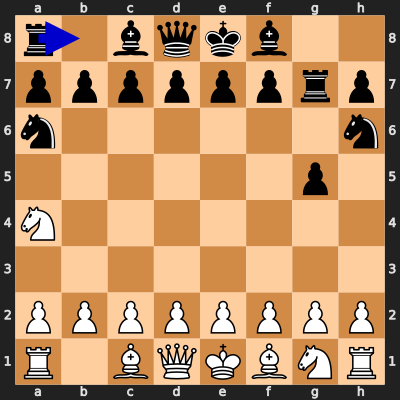

In [9]:
for _ in range(10):
    move = get_next_move(board)
    draw_board_with_move(move)
    board.push(move)

# Problems

- the search function `minimax` is not aware about the color
- the eval function `evaluate` only sums the material without considering the relative position of each piece

## Color Awareness

In order to make the minimax function aware of the color, a sign can be introduced (`-1`, `1`). The algorithm then becomes `negamax`.


In [10]:
def negamax(board: chess.Board, depth:int):
    if depth == 0 or board.is_game_over():
        return evaluate(board)

    max_score = -INF
    for move in board.legal_moves:
        board.push(move)
        # invert the sign/score, because the next move is made by the opponent
        score = -negamax(board, depth - 1)
        board.pop()
        max_score = max(max_score, score)

    return max_score


# Positional Awareness

The following features are indicators that a player is more likely to win:

- having more material is good
- having more mobility is good
- king safety is good
- center control is good

For each property a distinct evaluation function can be defined:

- **material** can be expressed as the sum of all pieces based on their value
- **mobility** can be expressed as the number of possible moves
- **king safety** can be expressed as the number of attacking pieces
- **center control** can be expressed by assigning higher numbers to center pieces


# Material

```txt
materialScore = kingWt  * (wK-bK)
              + queenWt * (wQ-bQ)
              + rookWt  * (wR-bR)
              + knightWt* (wN-bN)
              + bishopWt* (wB-bB)
              + pawnWt  * (wP-bP)
```

The weights can differ based on the position of each piece. A central knight is worth more than a knight at the border of the game. Thankfully, there are positional tables for each piece available at [chessprogramming.org](https://www.chessprogramming.org/Simplified_Evaluation_Function). These tables give bonuses for pieces standing well and penalties for pieces standing badly.


In [11]:
import functools

PAWN_WEIGHT = 100
KNIGHT_WEIGHT = 300
BISHOP_WEIGHT = 350  # in my opinion, a bishop is worth more than a knight
ROOK_WEIGHT = 500
QUEEN_WEIGHT = 900
KING_WEIGHT = 10_000


def eval_material(board: chess.Board):
    pieces = board.pieces
    white_pieces = functools.partial(pieces, color=chess.WHITE)
    black_pieces = functools.partial(pieces, color=chess.BLACK)

    raw_material = (KING_WEIGHT * (len(white_pieces(chess.KING)) - len(black_pieces(chess.KING)))
                    + QUEEN_WEIGHT * (len(white_pieces(chess.QUEEN)) - len(black_pieces(chess.QUEEN)))
                    + ROOK_WEIGHT * (len(white_pieces(chess.ROOK)) - len(black_pieces(chess.ROOK)))
                    + BISHOP_WEIGHT * (len(white_pieces(chess.BISHOP)) - len(black_pieces(chess.BISHOP)))
                    + KNIGHT_WEIGHT * (len(white_pieces(chess.KNIGHT)) - len(black_pieces(chess.KNIGHT)))
                    + PAWN_WEIGHT * (len(white_pieces(chess.PAWN)) - len(black_pieces(chess.PAWN))))
    return raw_material

This looks better. But the computer still places the pieces at the side of the board...

In [52]:
PAWN_POS_TABLE = [
 0,  0,  0,  0,  0,  0,  0,  0,
 5, 10, 10,-20,-20, 10, 10,  5,
 5, -5,-10,  0,  0,-10, -5,  5,
 0,  0,  0, 20, 20,  0,  0,  0,
 5,  5, 10, 25, 25, 10,  5,  5,
10, 10, 20, 30, 30, 20, 10, 10,
50, 50, 50, 50, 50, 50, 50, 50,
 0,  0,  0,  0,  0,  0,  0,  0]

KNIGHT_POS_TABLE = [
-50,-40,-30,-30,-30,-30,-40,-50,
-40,-20,  0,  5,  5,  0,-20,-40,
-30,  5, 10, 15, 15, 10,  5,-30,
-30,  0, 15, 20, 20, 15,  0,-30,
-30,  5, 15, 20, 20, 15,  5,-30,
-30,  0, 10, 15, 15, 10,  0,-30,
-40,-20,  0,  0,  0,  0,-20,-40,
-50,-40,-30,-30,-30,-30,-40,-50]

BISHOP_POS_TABLE = [
-20,-10,-10,-10,-10,-10,-10,-20,
-10,  5,  0,  0,  0,  0,  5,-10,
-10, 10, 10, 10, 10, 10, 10,-10,
-10,  0, 10, 10, 10, 10,  0,-10,
-10,  5,  5, 10, 10,  5,  5,-10,
-10,  0,  5, 10, 10,  5,  0,-10,
-10,  0,  0,  0,  0,  0,  0,-10,
-20,-10,-10,-10,-10,-10,-10,-20]

ROOK_POS_TABLE = [
  0,  0,  0,  5,  5,  0,  0,  0,
 -5,  0,  0,  0,  0,  0,  0, -5,
 -5,  0,  0,  0,  0,  0,  0, -5,
 -5,  0,  0,  0,  0,  0,  0, -5,
 -5,  0,  0,  0,  0,  0,  0, -5,
 -5,  0,  0,  0,  0,  0,  0, -5,
  5, 10, 10, 10, 10, 10, 10,  5,
 0,  0,  0,  0,  0,  0,  0,  0]

QUEEN_POS_TABLE = [
-20,-10,-10, -5, -5,-10,-10,-20,
-10,  0,  0,  0,  0,  0,  0,-10,
-10,  5,  5,  5,  5,  5,  0,-10,
  0,  0,  5,  5,  5,  5,  0, -5,
 -5,  0,  5,  5,  5,  5,  0, -5,
-10,  0,  5,  5,  5,  5,  0,-10,
-10,  0,  0,  0,  0,  0,  0,-10,
-20,-10,-10, -5, -5,-10,-10,-20]

KING_POS_TABLE = [
 20, 30, 10,  0,  0, 10, 30, 20,
 20, 20,  0,  0,  0,  0, 20, 20,
-10,-20,-20,-20,-20,-20,-20,-10,
-20,-30,-30,-40,-40,-30,-30,-20,
-30,-40,-40,-50,-50,-40,-40,-30,
-30,-40,-40,-50,-50,-40,-40,-30,
-30,-40,-40,-50,-50,-40,-40,-30,
-30,-40,-40,-50,-50,-40,-40,-30]


def eval_material(board: chess.Board):
    pieces = board.pieces
    white_pieces = functools.partial(pieces, color=chess.WHITE)
    black_pieces = functools.partial(pieces, color=chess.BLACK)


    # Raw Material
    raw_material = (KING_WEIGHT * (len(white_pieces(chess.KING)) - len(black_pieces(chess.KING)))
                    + QUEEN_WEIGHT * (len(white_pieces(chess.QUEEN)) - len(black_pieces(chess.QUEEN)))
                    + ROOK_WEIGHT * (len(white_pieces(chess.ROOK)) - len(black_pieces(chess.ROOK)))
                    + BISHOP_WEIGHT * (len(white_pieces(chess.BISHOP)) - len(black_pieces(chess.BISHOP)))
                    + KNIGHT_WEIGHT * (len(white_pieces(chess.KNIGHT)) - len(black_pieces(chess.KNIGHT)))
                    + PAWN_WEIGHT * (len(white_pieces(chess.PAWN)) - len(black_pieces(chess.PAWN))))

    # Piece-Square Values
    pawn_sq = sum(PAWN_POS_TABLE[i] for i in white_pieces(chess.PAWN)) - sum(PAWN_POS_TABLE[chess.square_mirror(i)] for i in black_pieces(chess.PAWN))
    knight_sq = sum(KNIGHT_POS_TABLE[i] for i in white_pieces(chess.KNIGHT)) - sum(KNIGHT_POS_TABLE[chess.square_mirror(i)] for i in black_pieces(chess.KNIGHT))
    bishop_sq = sum(BISHOP_POS_TABLE[i] for i in white_pieces(chess.BISHOP)) - sum(BISHOP_POS_TABLE[chess.square_mirror(i)] for i in black_pieces(chess.BISHOP))
    rook_sq = sum(ROOK_POS_TABLE[i] for i in white_pieces(chess.ROOK)) - sum(ROOK_POS_TABLE[chess.square_mirror(i)] for i in black_pieces(chess.ROOK))
    queen_sq = sum(QUEEN_POS_TABLE[i] for i in white_pieces(chess.QUEEN)) - sum(QUEEN_POS_TABLE[chess.square_mirror(i)] for i in black_pieces(chess.QUEEN))
    king_sq = sum(KING_POS_TABLE[i] for i in white_pieces(chess.KING)) - sum(KING_POS_TABLE[chess.square_mirror(i)] for i in black_pieces(chess.KING))

    total = raw_material + pawn_sq + bishop_sq + rook_sq + queen_sq + king_sq
    return total


In [13]:
def evaluate(board: chess.Board) -> int:
    if board.is_checkmate():
        if board.turn:
            return -INF
        else:
            return INF
    if board.is_stalemate():
        return 0
    if board.is_insufficient_material():
        return 0

    material_score = eval_material(board)
    return material_score if board.turn else material_score * -1


In [14]:
def get_next_move(board: chess.Board) -> chess.Move:
    best_move = None
    best_score = -INF

    for move in board.legal_moves:
        board.push(move)
        score = -negamax(board, DEPTH - 1)
        board.pop()
        if score > best_score:
            best_score = score
            best_move = move
    return best_move

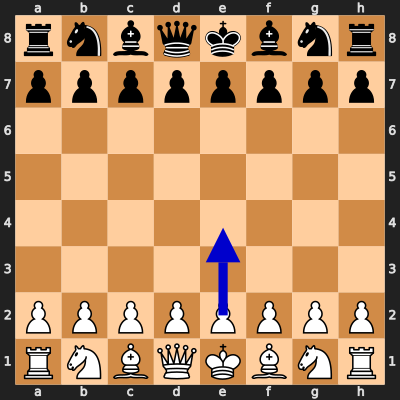

In [15]:
board = chess.Board()

move = get_next_move(board)
draw_board_with_move(move)
board.push(move)

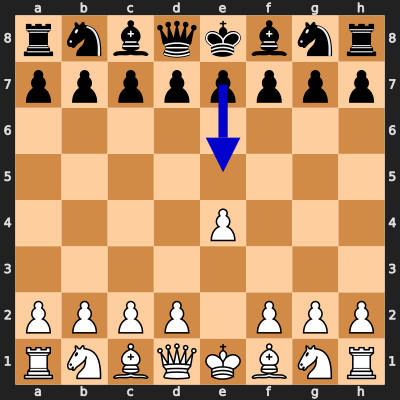

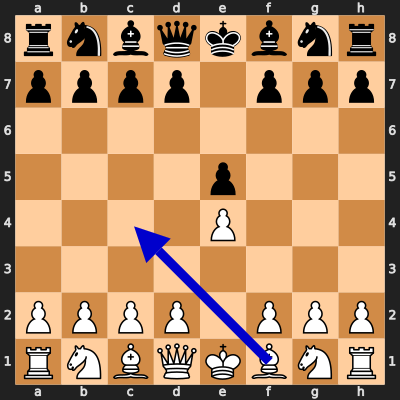

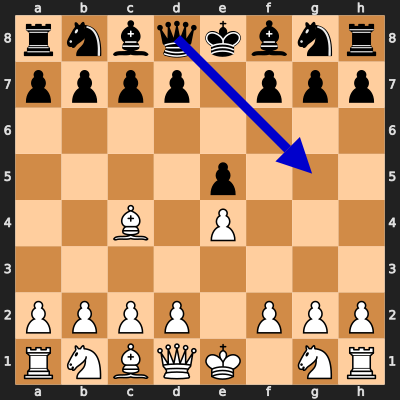

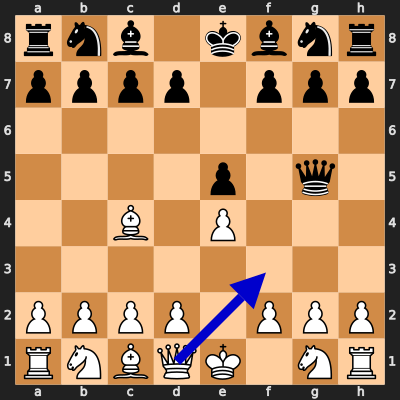

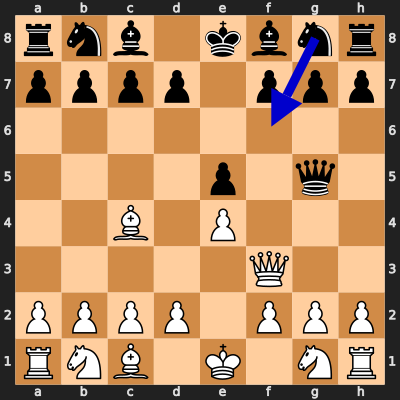

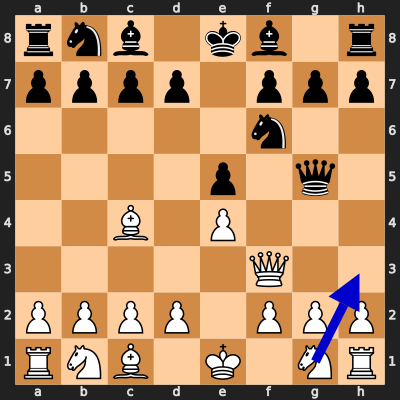

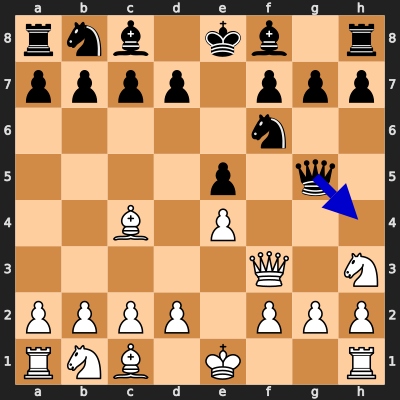

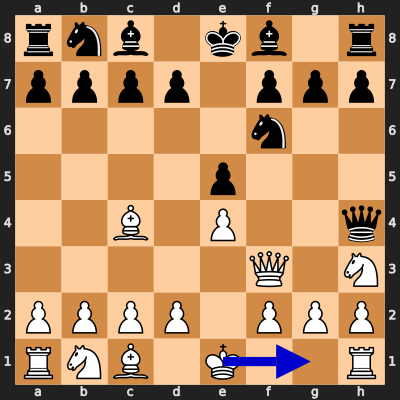

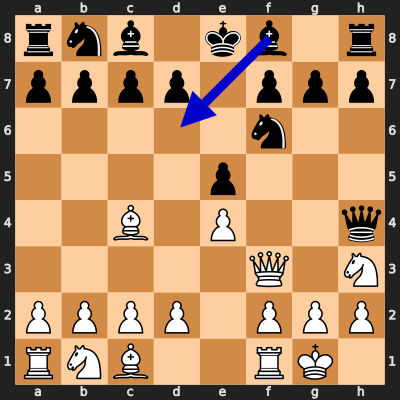

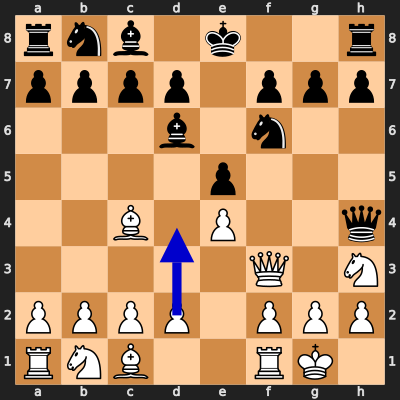

In [16]:
for _ in range(10):
    move = get_next_move(board)
    draw_board_with_move(move)
    board.push(move)

# Alpha/Beta pruning

**Goal**: Reduce the number of nodes in the search tree to look at

**Benefit**: Eliminate the need to search large portions of the search tree. Thus, allow for a higher search depth.

**Idea**: You can stop looking at the search tree, if the opponent would never allow this move, because there is a better way to prevent it.

- [a good visualization](https://www.youtube.com/watch?v=l-hh51ncgDI)
- remember: the search tree is built bottom up
  - white selects the maximizing value of the layer below
  - black selects the minimizing value of the layer below
  - and so on... 
- chess is a **zero-sum game**: _"One player's lower advantage is the other player's disadvantage"_
- maintain two values:
   - `alpha`: minimum score that the maximizing player is assured of
   - `beta`: maximum score that the minimizing player is assured of
- these two values represent the worst case scenario


```mermaid
flowchart TD
    subgraph max
        A
    end

    subgraph min
        B
        C
    end

    subgraph maxx[max]
        D
        G
        J
        L
    end

    subgraph minn[min]
        H
        I
        K
        E
        F
        M
        O
        P
    end

    A[3] --> B[3]
    A -->|worse for white| C[-4]

    B --> D[3]
    D --> E[-1]
    D --> F[3]
    B -->|worse for black| G[5]
    G --> H[5]
    G -.-> I[?]

    C --> J[-4]
    C -.-> L[?]
    J --> K[-6]
    J --> M[-4]
    L -.-> O[?]
    L -.-> P[?]

```

In this example:

- black would choose to play the move that leads to the score of 3 in layer 2, because `min(3,5)=3`
  - thus, the remaining search tree is irrelevant, because black would never allow it
- white would choose to play the move leads to the score of 3 in layer 1, because `max(3, -4)=3`
  - thus, the remaining search three is irrelevant, because white would never go down this route  


In [17]:
def negamax(board, depth, alpha=-10_000, beta=10_000):
    if depth == 0 or board.is_game_over():
        return evaluate(board)

    max_score = -INF
    for move in board.legal_moves:
        board.push(move)
        score = -negamax(board, depth - 1, -beta, -alpha)
        board.pop()
        max_score = max(max_score, score)
        alpha = max(alpha, score)
        if alpha >= beta:
            break  # Beta cut-off
    return max_score

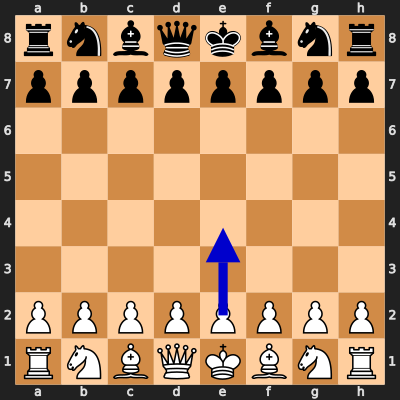

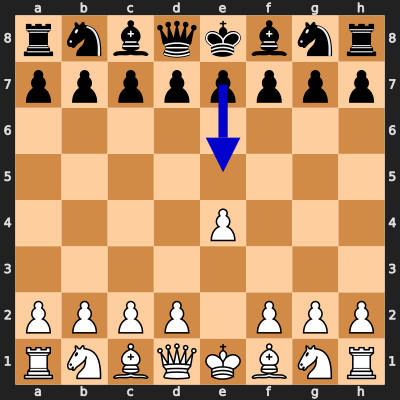

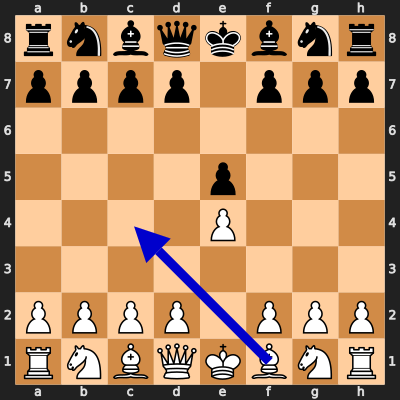

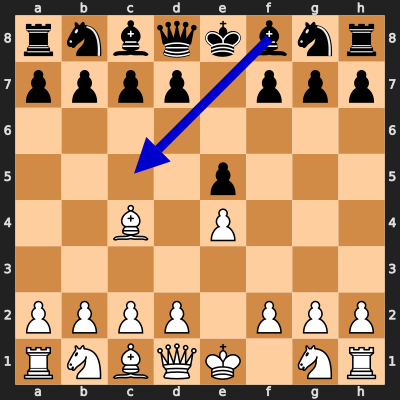

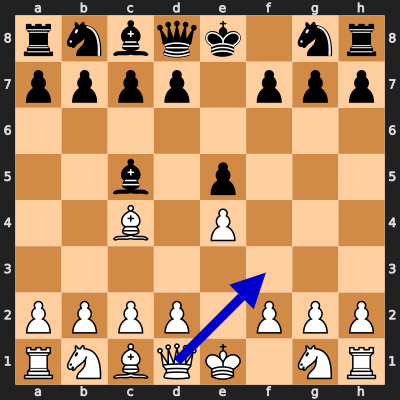

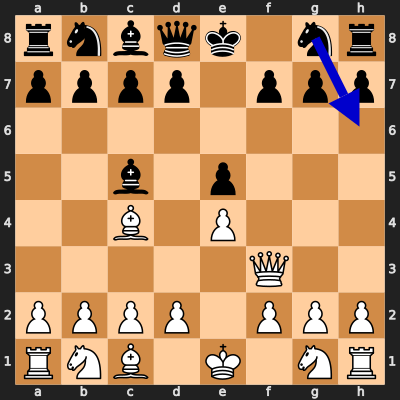

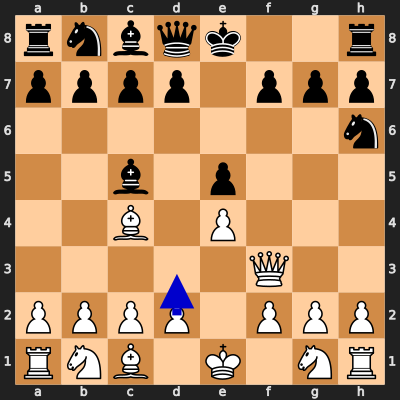

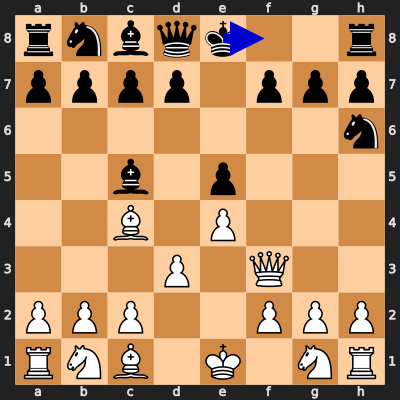

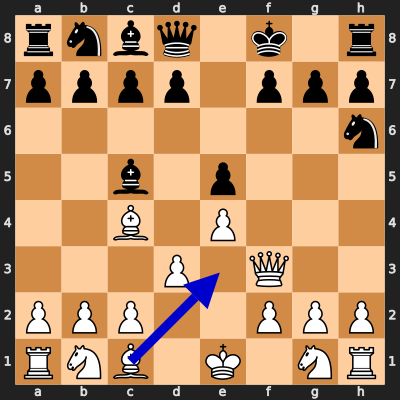

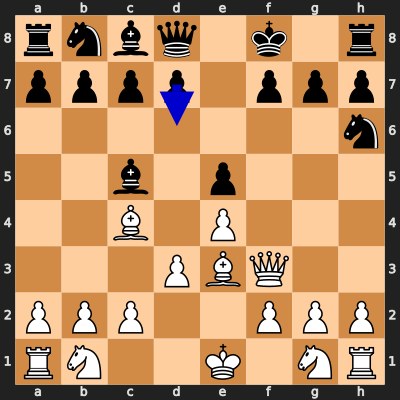

In [18]:
DEPTH = 4
board = chess.Board()
for _ in range(10):
    move = get_next_move(board)
    draw_board_with_move(move)
    board.push(move)

# Horizon Effect

By stopping at a search depth of 0 has a certain risk. A queen may take a pawn. But because the search did not consider the next move (`depth==0`) the player may loose a queen if the opponent takes back. This can be prevented through a [Quiescence Search](https://www.chessprogramming.org/Quiescence_Search).

In [19]:
def quiesce(board, alpha, beta):
    stand_pat = evaluate(board)
    if stand_pat >= beta:
        return beta
    if alpha < stand_pat:
        alpha = stand_pat

    for move in board.legal_moves:
        if board.is_capture(move):
            board.push(move)
            score = -quiesce(board, -beta, -alpha)
            board.pop()

            if score >= beta:
                return beta
            if score > alpha:
                alpha = score
    return alpha

def negamax(board, depth, alpha=-10_000, beta=10_000):
    if depth == 0 or board.is_game_over():
        # search for dangerous moves
        return quiesce(board, alpha, beta)

    max_score = -INF
    for move in board.legal_moves:
        board.push(move)
        score = -negamax(board, depth - 1, -beta, -alpha)
        board.pop()
        max_score = max(max_score, score)
        alpha = max(alpha, score)
        if alpha >= beta:
            break  # Beta cut-off
    return max_score

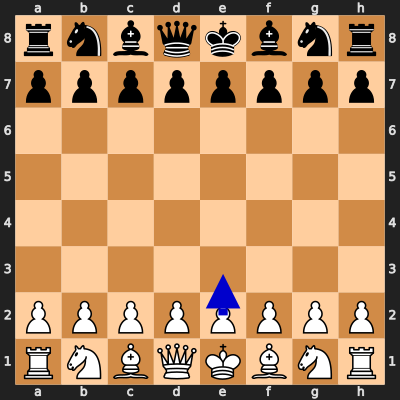

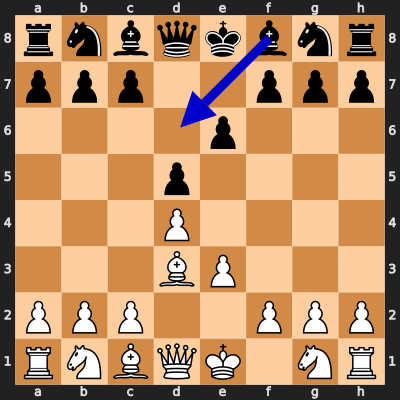

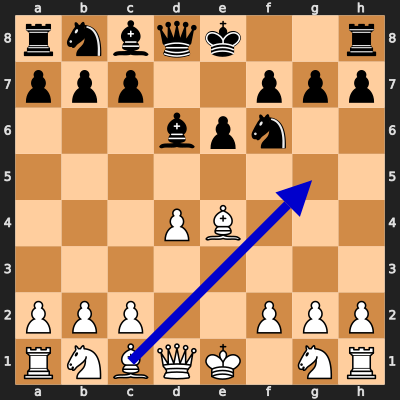

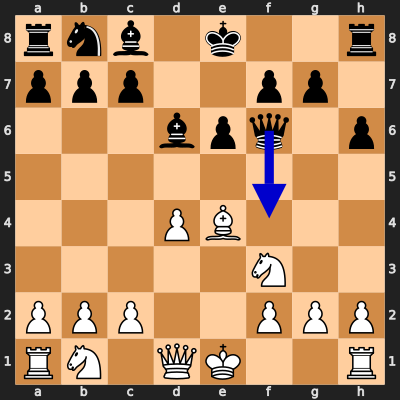

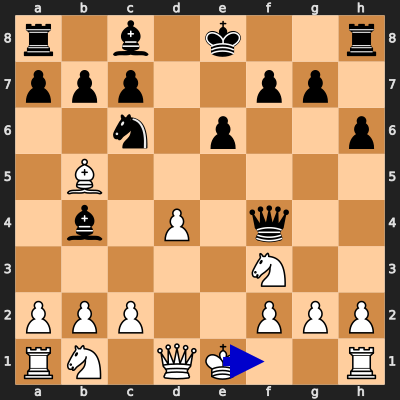

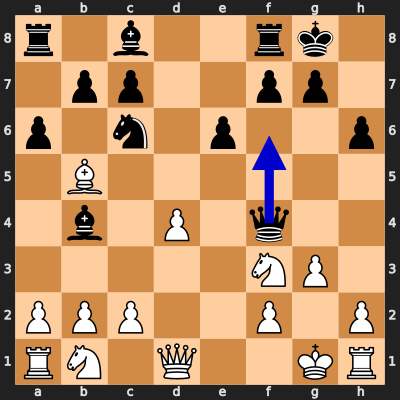

KeyboardInterrupt: 

In [20]:
DEPTH = 3
board = chess.Board()
for _ in range(60):
    if board.is_game_over():
        break
    move = get_next_move(board)
    if _ % 5 == 0:
        draw_board_with_move(move)
    board.push(move)

# Move Order

The possibility to prune depends on the evaluation order of moves. Take this slightly changed order of moves for the previous tree (the other leg is omitted for brevity):


```mermaid
flowchart TD
    subgraph max
        A
    end

    subgraph min
        B
        C
    end

    subgraph maxx[max]
        D
        G
    end

    subgraph minn[min]
        H
        I
        E
        F
    end

    A[3] --> B[3]
    A -->C[X]

    B --> D[3]
    D --> E[-1]
    D --> F[3]
    B --> G[5]
    G --> H[1]
    G -.-> I[5]
```

Here, no pruning is possible, because there are better moves for black in the lower left leg that would be chosen by black - but are evaluated last.

Thus, it makes sense **to order the moves based on how likely they are to be good.**


# Iterative Search

Currently, the evaluation function re-evaluates the whole board for every move. Because the board only differs by one move between every step of the search process these computations can be done incrementally. This requires the following adaptions/additions:

- `mmove(board, move)`: make a move on the board **and** update the board score
- `umove(board, move)`: undo a move on the board **and** update the board score
- `ieval(board, move)`: incremental evulation function


In [147]:
PIECE_VALUES = {
    chess.PAWN: 100,
    chess.KNIGHT: 300,
    chess.BISHOP: 350,
    chess.ROOK: 500,
    chess.QUEEN: 900,
}


def get_piece_score_at(piece: chess.Piece, square: chess.Square) -> int:
    piece_type = piece
    if piece_type == chess.PAWN:
        return PAWN_POS_TABLE[square]
    elif piece_type == chess.KNIGHT:
        return KNIGHT_POS_TABLE[square]
    elif piece_type == chess.BISHOP:
        return BISHOP_POS_TABLE[square]
    elif piece_type == chess.ROOK:
        return ROOK_POS_TABLE[square]
    elif piece_type == chess.QUEEN:
        return QUEEN_POS_TABLE[square]
    else:
        return KING_POS_TABLE[square]


def ieval(board: chess.Board, move: chess.Move, board_score: int, turn):
    turn = 1 if turn else -1
    # Currently moving piece
    cur_piece = board.piece_type_at(move.from_square)

    # Add/Subtract the score of the old position
    board_score -= get_piece_score_at(cur_piece, move.from_square) * turn

    # Add/Subtract the new position
    board_score += get_piece_score_at(cur_piece, move.to_square) * turn

    # Castle
    if move.from_square == chess.E1 and move.to_square == chess.G1:
        board_score -= ROOK_POS_TABLE[chess.H1]
        board_score += ROOK_POS_TABLE[chess.F1]
    elif move.from_square == chess.E1 and move.to_square == chess.C1:
        board_score -= ROOK_POS_TABLE[chess.A1]
        board_score += ROOK_POS_TABLE[chess.D1]
    elif move.from_square == chess.E8 and move.to_square == chess.G8:
        board_score += ROOK_POS_TABLE[chess.H8]
        board_score -= ROOK_POS_TABLE[chess.F8]
    elif move.from_square == chess.E8 and move.to_square == chess.C8:
        board_score += ROOK_POS_TABLE[chess.A8]
        board_score -= ROOK_POS_TABLE[chess.D8]

    #  Update material
    if board.is_en_passant(move):
        if turn:
            captured_piece = board.piece_type_at(chess.square(move.to_square % 8, move.to_square // 8 - 1))
        else:
            captured_piece = board.piece_type_at(chess.square(move.to_square % 8, move.to_square // 8 + 1))
        board_score += PIECE_VALUES[captured_piece] * turn
    elif board.is_capture(move):
        captured_piece = board.piece_type_at(move.to_square)
        board_score += PIECE_VALUES[captured_piece] * turn

    # Handle Promotion
    if move.promotion:
        # Material new piece
        board_score += PIECE_VALUES[move.promotion] * turn
        # Material old piece
        board_score -= PIECE_VALUES[cur_piece] * turn
        # Score old position
        board_score -= get_piece_score_at(cur_piece, move.to_square) * turn
        # Add/Subtract the new position
        board_score += get_piece_score_at(move.promotion, move.to_square) * turn

    return board_score

In [97]:
def evaluate(board: chess.Board, board_score: int) -> int:
    if board.is_checkmate():
        if board.turn:
            return -INF
        else:
            return INF
    if board.is_stalemate():
        return 0
    if board.is_insufficient_material():
        return 0

    return board_score if board.turn else board_score * -1

In [105]:
def mmove(board, move, board_score):
    board_score = ieval(board, move, board_score, board.turn)
    board.push(move)
    return board_score

def umove(board, board_score):
    move = board.pop()
    return ieval(board, move, board_score, not board.turn)

In [123]:
def quiesce(board, alpha, beta, board_score):
    stand_pat = evaluate(board, board_score)
    if stand_pat >= beta:
        return beta
    if alpha < stand_pat:
        alpha = stand_pat

    for move in board.legal_moves:
        if board.is_capture(move):
            board_score = mmove(board, move, board_score)
            score = -quiesce(board, -beta, -alpha, board_score)
            board_score = umove(board, board_score)
            if score >= beta:
                return beta
            if score > alpha:
                alpha = score
    return alpha


def negamax(board, depth, board_score, alpha=-10_000, beta=10_000):
    if depth == 0 or board.is_game_over():
        # search for dangerous moves
        return quiesce(board, alpha, beta, board_score)

    max_score = -INF
    for move in board.legal_moves:
        board_score = mmove(board, move, board_score)
        score = -negamax(board, depth - 1, board_score, -beta, -alpha)
        board_score = umove(board, board_score)
        max_score = max(max_score, score)
        alpha = max(alpha, score)
        if alpha >= beta:
            break  # Beta cut-off
    return max_score


def get_next_move(board: chess.Board) -> chess.Move:
    best_move = None
    best_score = -INF
    board_score = eval_material(board)

    for move in board.legal_moves:
        board_score = mmove(board, move, board_score)
        score = -negamax(board, DEPTH - 1, board_score)
        board_score = umove(board, board_score)
        if score > best_score:
            best_score = score
            best_move = move
    return best_move

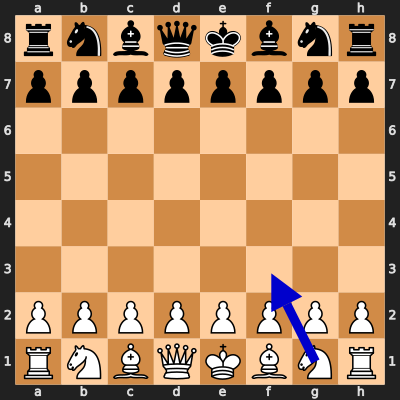

SCORE: 0


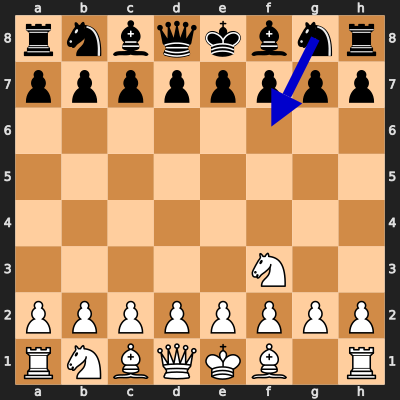

SCORE: 0


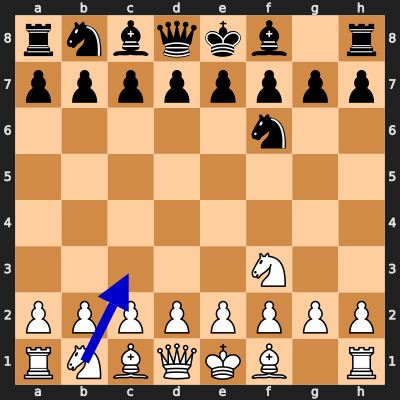

SCORE: 0


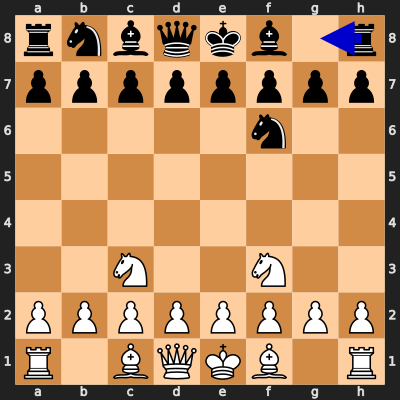

SCORE: 0


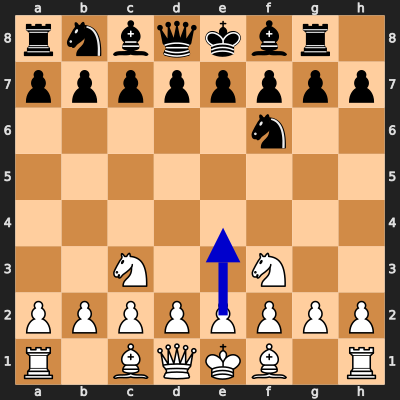

SCORE: 40


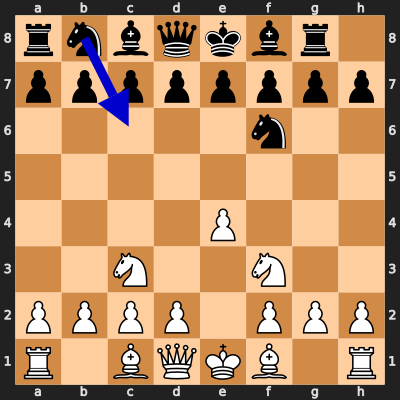

SCORE: 40


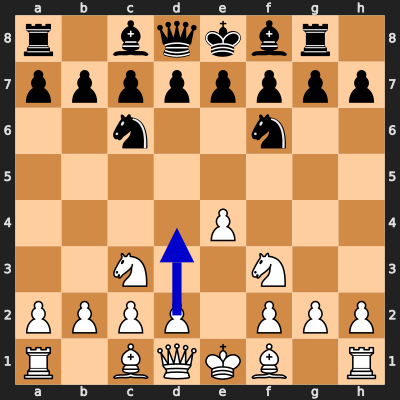

SCORE: 80


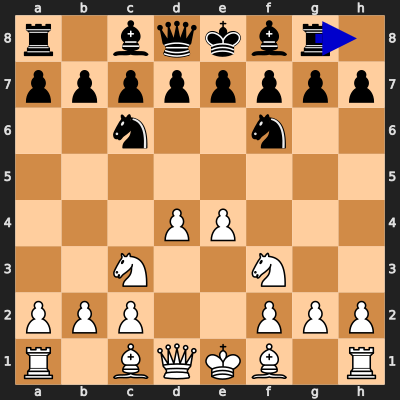

SCORE: 80


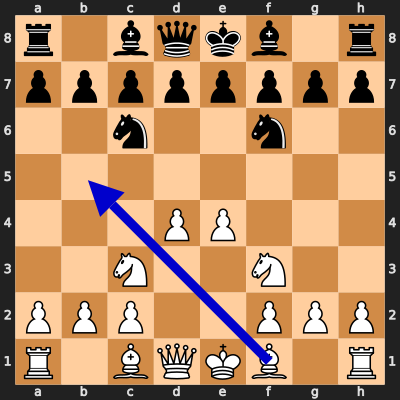

SCORE: 95


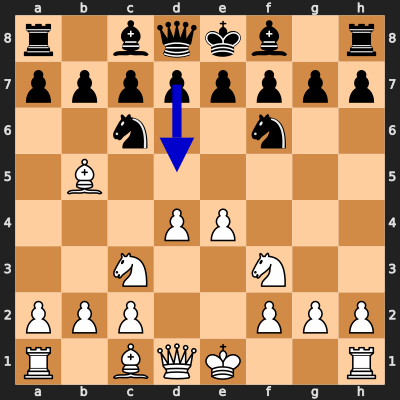

SCORE: 55


In [148]:
DEPTH = 4
board = chess.Board()
for _ in range(10):
    if board.is_game_over():
        break
    move = get_next_move(board)
    draw_board_with_move(move)
    board.push(move)
    print('SCORE:', eval_material(board))

True


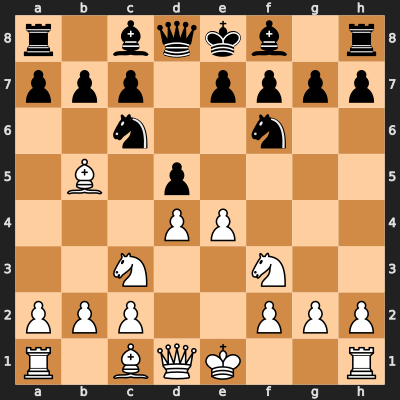

In [149]:
print(board.turn)
svg = chess.svg.board(board, size=400, arrows=[])
display.display(svg)

In [150]:
for move in board.legal_moves:
    try:
        x = mmove(board, move, board_score)
        y = umove(board, x)
        print(move, board_score, x, y)
        assert y == board_score
    except Exception:
        print(move)
        raise

b5c6 0 300 0
b5a6 0 -15 0
b5c4 0 5 0
b5a4 0 -15 0
b5d3 0 5 0
b5e2 0 -5 0
b5f1 0 -15 0
f3g5 0 -5 0
f3e5 0 10 0
f3h4 0 -40 0
f3d2 0 -5 0
f3g1 0 -50 0
c3d5 0 110 0
c3a4 0 -40 0
c3e2 0 -5 0
c3b1 0 -50 0
h1g1 0 0 0
h1f1 0 0 0
e1e2 0 0 0
e1d2 0 0 0
e1f1 0 10 0
d1d3 0 10 0
d1e2 0 5 0
d1d2 0 5 0
c1h6 0 0 0
c1g5 0 15 0
c1f4 0 20 0
c1e3 0 20 0
c1d2 0 10 0
a1b1 0 0 0
e1g1 0 30 0
e4d5 0 105 0
e4e5 0 5 0
h2h3 0 0 0
g2g3 0 -15 0
b2b3 0 -15 0
a2a3 0 0 0
h2h4 0 -5 0
g2g4 0 -10 0
b2b4 0 -10 0
a2a4 0 -5 0


In [151]:
# TODO: Why does black move its rook back and forth? There seems to be a bug in the eval function for black.